## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import torch
from time_deconv.time_deconv import *

# Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


# Run Deconvolution

In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 10,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
batch = generate_batch(pseudo_time_reg_deconv.dataset, device, dtype)
c = torch.nn.functional.softmax(torch.rand([10,5]), dim=-1)
pseudo_time_reg_deconv.model(**batch)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=50_000, verbose=True, log_frequency=1000, clear_param_store=True)

[iteration: 0]   loss: 30368180.39
[iteration: 1000]   loss: 8946585.50
[iteration: 2000]   loss: 3625971.38
[iteration: 3000]   loss: 2062615.53
[iteration: 4000]   loss: 1486526.05
[iteration: 5000]   loss: 1226849.58
[iteration: 6000]   loss: 1095934.01
[iteration: 7000]   loss: 1026312.07
[iteration: 8000]   loss: 988502.74
[iteration: 9000]   loss: 967851.71
[iteration: 10000]   loss: 956532.40
[iteration: 11000]   loss: 950277.48
[iteration: 12000]   loss: 946649.66
[iteration: 13000]   loss: 944478.45
[iteration: 14000]   loss: 943126.04
[iteration: 15000]   loss: 942100.25
[iteration: 16000]   loss: 941353.81
[iteration: 17000]   loss: 940865.03
[iteration: 18000]   loss: 940638.15
[iteration: 19000]   loss: 940525.28
[iteration: 20000]   loss: 940455.47
[iteration: 21000]   loss: 940425.64
[iteration: 22000]   loss: 940271.90
[iteration: 23000]   loss: 940176.15
[iteration: 24000]   loss: 940090.58
[iteration: 25000]   loss: 939956.70
[iteration: 26000]   loss: 939851.47
[iter

# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

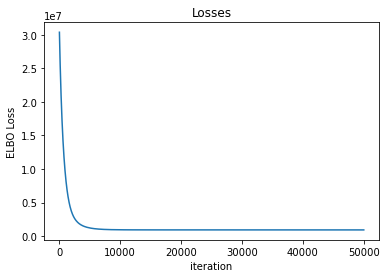

In [19]:
# Plot the loses
pseudo_time_reg_deconv.plot_loss()

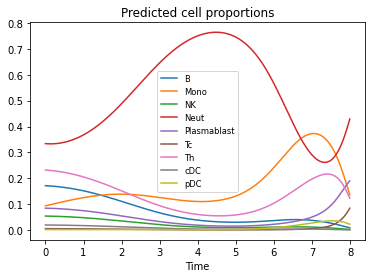

In [12]:
# calculate and plot the composition trajectories
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

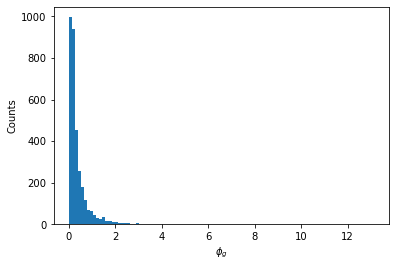

In [21]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

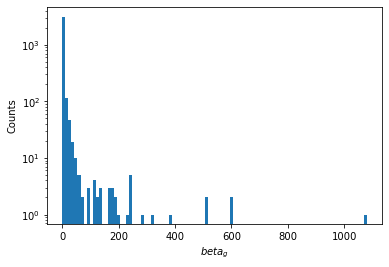

In [22]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

Text(0.5, 1.0, 'Last few Dirichlet $ \\alpha $ Values')

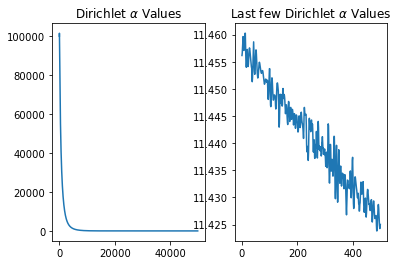

In [34]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha_prior'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')
